### Imports

In [53]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import polars as pl
import numpy as np

from datetime import datetime

from hmmlearn.hmm import GaussianHMM
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt

# Verify all libraries are imported correctly
print("Libraries imported successfully")

Libraries imported successfully


### Data Management

In [54]:
# Import necessary libraries
import yfinance as yf

# Set start and end dates for the data extraction
start_date = "2019-01-01"
end_date = "2024-07-01"
symbol = "XLV"

# Fetch data using yfinance
data = yf.download(symbol, start=start_date, end=end_date)

# USD_JPY = yf.Ticker("USDJPY=X")
# df_usd_jpy = USD_JPY.history(periods="max")
# df_usd_jpy.head()


[*********************100%%**********************]  1 of 1 completed


In [55]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,85.180000,85.830002,84.269997,85.199997,77.548515,14179900
2019-01-03,85.320000,85.500000,83.250000,83.470001,75.973915,17668000
2019-01-04,84.449997,86.430000,84.410004,85.959999,78.240295,16262600
2019-01-07,85.989998,87.099998,85.730003,86.290001,78.540649,12387200
2019-01-08,86.980003,87.250000,86.000000,86.959999,79.150482,13371000


In [56]:
# Convert to Polars DataFrame and include dates
import polars as pl

data.reset_index(inplace=True) # need to add the date as index otherwise it will drop the date during conversion
data = pl.DataFrame(data)

# Select relevant columns: Date, Open, High, Low, Adj Close, and Volume
data = data.select(["Date", "Open", "High", "Low", "Adj Close", "Volume"])

In [57]:

print(data.columns)
print(data.schema)

['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume']
OrderedDict({'Date': Datetime(time_unit='ns', time_zone=None), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Adj Close': Float64, 'Volume': Int64})


In [58]:
data.head(3)

Date,Open,High,Low,Adj Close,Volume
datetime[ns],f64,f64,f64,f64,i64
2019-01-02 00:00:00,85.18,85.830002,84.269997,77.548515,14179900
2019-01-03 00:00:00,85.32,85.5,83.25,75.973915,17668000
2019-01-04 00:00:00,84.449997,86.43,84.410004,78.240295,16262600


In [59]:
# Create a copy of the dataframe and add returns and range columns
df = data.clone()

# Calculate daily returns
df = df.with_columns((pl.col("Adj Close") / pl.col("Adj Close").shift(1) - 1).alias("Returns")) # the -1 returns the percent return in decimals

# Calculate daily range (volatility)
df = df.with_columns((pl.col("High") / pl.col("Low")-1).alias("Range")) # the -1 returns the percent return in decimals

# Drop NaN values created by the pct_change method
# In Polars, the drop_nulls method does not require the inplace=True parameter as it returns a new DataFrame by default. 
df = df.drop_nulls()

# Display the updated dataframe with new columns
df.head()

Date,Open,High,Low,Adj Close,Volume,Returns,Range
datetime[ns],f64,f64,f64,f64,i64,f64,f64
2019-01-03 00:00:00,85.32,85.5,83.25,75.973915,17668000,-0.020305,0.027027
2019-01-04 00:00:00,84.449997,86.43,84.410004,78.240295,16262600,0.029831,0.023931
2019-01-07 00:00:00,85.989998,87.099998,85.730003,78.540649,12387200,0.003839,0.01598
2019-01-08 00:00:00,86.980003,87.25,86.0,79.150482,13371000,0.007765,0.014535
2019-01-09 00:00:00,87.339996,87.860001,87.089996,79.505463,11259700,0.004485,0.008841


In [60]:
df.tail()

Date,Open,High,Low,Adj Close,Volume,Returns,Range
datetime[ns],f64,f64,f64,f64,i64,f64,f64
2024-06-24 00:00:00,146.830002,147.610001,146.449997,147.089996,6446100,0.005833,0.007921
2024-06-25 00:00:00,147.259995,147.470001,146.279999,146.630005,5171600,-0.003127,0.008135
2024-06-26 00:00:00,146.369995,146.630005,145.770004,146.110001,4572700,-0.003546,0.0059
2024-06-27 00:00:00,146.220001,146.279999,145.029999,145.869995,4637900,-0.001643,0.008619
2024-06-28 00:00:00,146.410004,147.020004,145.100006,145.75,7656800,-0.000823,0.013232


## Structure Data

In [61]:
# Structure Data
X_train = df.select(['Returns', 'Range']) # in polars we use .select

# Display the first few rows of the structured data
X_train.head()

Returns,Range
f64,f64
-0.020305,0.027027
0.029831,0.023931
0.003839,0.01598
0.007765,0.014535
0.004485,0.008841


Hidden Markov Model (HMM) for Market Analysis
Overview
This notebook demonstrates how to use a Hidden Markov Model (HMM) to analyze market states using financial data.
Data Preparation

We're using SPI (S&P 500 Index) data from 2017 to 2022.
The data includes features like returns and ranges.

Training the HMM
Import required libraries

## HMM Learning

In [62]:
#Data Preparation
import polars as pl
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Convert Polars DataFrame to NumPy array
X_train_np = X_train.to_numpy()
print("Shape of X_train_np:", X_train_np.shape)

# Display first few rows of the data
print("\nFirst few rows of X_train_np:")
print(X_train_np[:5])

# Determine the number of features
n_features = X_train_np.shape[1]
print(f"\nNumber of features detected: {n_features}")

# Comments:
# - We convert the Polars DataFrame to a NumPy array because HMM requires this format.
# - The shape of X_train_np tells us how many trading days (rows) and features (columns) we have.
# - For trading, we typically use 2 features: returns and volatility (or range).
# - Checking the first few rows helps us verify that our data looks correct (e.g., reasonable values for returns and volatility).
# - The number of features is crucial for properly configuring our HMM to detect market regimes.

Shape of X_train_np: (1381, 2)

First few rows of X_train_np:
[[-0.02030471  0.02702703]
 [ 0.02983103  0.02393077]
 [ 0.00383887  0.01598035]
 [ 0.00776455  0.01453488]
 [ 0.00448488  0.00884148]]

Number of features detected: 2


In [63]:
# Fit Model
hmm_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

# Comments:
# - We use GaussianHMM instead of GMM (Gaussian Mixture Model) as it's better suited for time series data in trading.
# - n_components=4: We assume 4 hidden market states (e.g., bull, bear, sideways, volatile).
# - covariance_type="full": Allows for complex relationships between features, capturing nuanced market dynamics.
# - n_iter=100: Maximum number of iterations for the training algorithm. Adjust if needed for convergence.
# - .fit(X_train): Trains the model on our historical market data in one step.
# - The model score is the log-likelihood of the data given the model. Higher values indicate better fit.
# - In trading, a well-fitted model can more accurately identify current market regimes and potentially predict transitions.

Model Score: 9947.463449705585


In [64]:
# Check Results
hidden_states = hmm_model.predict(X_train)
print("First 20 hidden states:", hidden_states[:20])
print("\nUnique states:", np.unique(hidden_states))
print("\nState frequencies:")
for i in range(hmm_model.n_components):
    print(f"State {i}: {np.sum(hidden_states == i) / len(hidden_states):.2%}")

# Comments:
# - model.predict() assigns the most likely hidden state to each data point in our trading time series.
# - In trading context, each state represents a different market regime (e.g., bullish, bearish, volatile, sideways).
# - The first 20 states give us a quick look at how the model interprets the beginning of our data.
# - Unique states confirm that all defined states (0 to 3) are being used.
# - State frequencies show how often each market regime occurs in our data.
# - This information can be used to:
#   1. Identify current market conditions.
#   2. Develop regime-specific trading strategies.
#   3. Analyze how different regimes affect trading performance.

First 20 hidden states: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Unique states: [0 1 2 3]

State frequencies:
State 0: 22.52%
State 1: 75.02%
State 2: 1.45%
State 3: 1.01%


In [65]:
# Regime state means for each feature
state_means = hmm_model.means_
state_means

array([[-0.00221249,  0.01841066],
       [ 0.00149662,  0.01004091],
       [-0.03215677,  0.04708853],
       [ 0.03990416,  0.0442594 ]])

In [66]:
# Regime state covariances for each feature
state_covars = hmm_model.covars_

state_covars

array([[[2.23699146e-04, 2.60495611e-05],
        [2.60495611e-05, 6.75500768e-05]],

       [[5.22563538e-05, 1.32174262e-05],
        [1.32174262e-05, 2.13688653e-05]],

       [[1.18797477e-03, 2.30751018e-04],
        [2.30751018e-04, 8.53564327e-04]],

       [[1.44980251e-03, 9.42420707e-04],
        [9.42420707e-04, 9.61930044e-04]]])

### Data Visualization

In [67]:
# Structure the prices for plotting
import polars as pl

# Initialize labels for each state
labels_0, labels_1, labels_2, labels_3 = [], [], [], []

# Get prices from the dataframe
prices = df["Adj Close"].to_numpy().astype(float)

# Verify that the number of prices matches the number of hidden states
print("Correct number of rows: ", len(prices) == len(hidden_states))

# Populate labels based on hidden states
for s, price in zip(hidden_states, prices):
    if s == 0:
        labels_0.append(price)
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif s == 1:
        labels_0.append(float('nan'))
        labels_1.append(price)
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(price)
        labels_3.append(float('nan'))
    elif s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(price)

# Comments:
# - This code prepares data for visualizing different market states.
# - We create separate lists for each state (0-3) to store prices.
# - The 'hidden_states' array contains the predicted market regime for each time point.
# - We populate the labels based on the hidden state:
#   - If state is 0, we put the price in labels_0 and NaN in others.
#   - This allows us to plot each state separately with gaps where it's not active.
# - In trading, this helps visualize:
#   1. When different market regimes occur (e.g., trending up, trending down, volatile).
#   2. How prices behave in each regime.
#   3. The frequency and duration of different market states.
# - This visualization can inform trading strategies, risk management, and market analysis.

Correct number of rows:  True


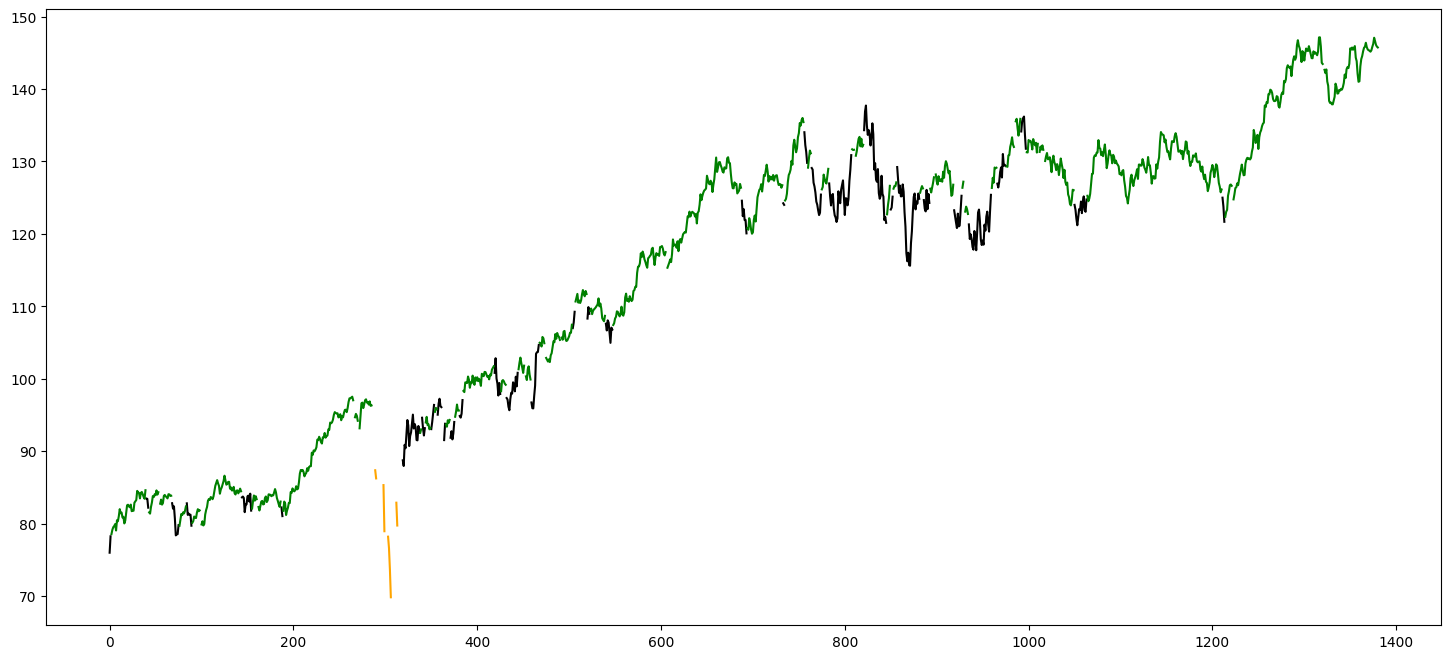

In [68]:
# Plot Chart 
fig = plt.figure(figsize=(18, 8))
plt.plot(labels_0, color='black')
plt.plot(labels_1, color='green')
plt.plot(labels_2, color='orange')
plt.plot(labels_3, color='red')
plt.show()